In [37]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import cv2 
from collections import Counter
import skimage
import os
from skimage import color
from skimage import io
import plotly
import plotly.express as px
import plotly.graph_objects as go
from skimage import data, filters, measure, morphology
from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

### GUI inputs

- Min and max contrast values of different color channels
- Image magnification  

### GUI outputs

- Txt file with the name of the images containing flake candidates 

## List of functons to be used in GUI

- Function that iterates using previous function and creates the txt file
> - function that checks image and determines whether it is a candidate or not.
> - function that makes a list of flake candidate names.
> - fucntion that creates the actual txt file

In [1]:
# This fucntion finds the most frequent alue in list and will be used to find the background value

def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0] 

In [3]:
# This function returns true if a flake candidate is found.  
# It requires the following parameters:
# - file directory (file_dir)
# - RGB minimum and maximum contrats values (r_val_min, r_val_max, g_val_min, g_val_max, b_val_min, b_val_max,) 
# - Area

def flake_candidate(file_dir, r_val_min, r_val_max, g_val_min, g_val_max, b_val_min, b_val_max, Area):
   
    ##################################################################
    #                        Read Image                              #
    ##################################################################

    # Read the image and get array
    image = cv2.imread(file_dir)

    # cv2.imread gets image in BGR2, with this line we turn it to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
    ##################################################################
    #                        Red channel                             #
    ##################################################################

    # This line gets the red channel 
    channel_r = image [:,:,0]

    # Here we find the Backround value
    list_r = channel_r.flatten()
    Backrgound_red = most_frequent(list_r)


    # Here we apply our mask to the red channel. We keep the pixels that meet the condition and turn the rest to 0.

    channel_r = image [:,:,0]
    # We define the formula to be applied
    r_ratios = (np.abs(channel_r - Backrgound_red))/(Backrgound_red + channel_r)
    # We use the formula to create the mask
    mask_r = np.logical_or(r_ratios<r_val_min, r_ratios > r_val_max)
    # We update our channel using the mask 
    channel_r[mask_r] = 0

    
    ##################################################################
    #                        Green channel                           #
    ##################################################################

    # This line gets the green channel 
    channel_g = image [:,:,1]

    # Here we find the Backround value
    list_g = channel_g.flatten()
    Backrgound_green = most_frequent(list_g)

    # Here we apply our mask to the red channel. We keep the pixels that meet the condition and turn the rest to 0.

    channel_g = image [:,:,1]
    # We define the formula to be applied
    g_ratios = (np.abs(channel_g - Backrgound_green ))/(Backrgound_green + channel_g)
    # We use the formula to create the mask
    mask_g = np.logical_or(g_ratios<g_val_min, g_ratios > g_val_max)
    # We update our channel using the mask 
    channel_g[mask_g] = 0


    ##################################################################
    #                        Blue channel                            #
    ##################################################################

    # This line gets the blue channel 

    channel_b = image [:,:,2]

    # Here we find the Backround value
    list_b = channel_b.flatten()
    Backrgound_blue = most_frequent(list_b)

    # Here we apply our mask to the red channel. We keep the pixels that meet the condition and turn the rest to 0.

    channel_b = image [:,:,2]
    # We define the formula to be applied
    b_ratios = (np.abs(channel_b - Backrgound_blue))/(Backrgound_blue + channel_b)
    # We use the formula to create the mask
    mask_b = np.logical_or(b_ratios<b_val_min, b_ratios >  b_val_max)
    # We update our channel using the mask 
    channel_b[mask_b] = 0

    ##################################################################
    #                        New Image                               #
    ##################################################################

    # After segmenting our color channels we can use them to create a new image and measure the area

    image [:,:,0] = channel_r
    image [:,:,1] = channel_g
    image [:,:,2] = channel_b

    # Skimage helps us get information of an image including the area of different regions in the image.
    # Here we can get a list of the "areas" of the the regions found in the image and can use this to target images
    # containing objects with a specific size  

    object_features = skimage.measure.regionprops(image)
    object_areas = [objf["area"] for objf in object_features]

    flakes = []

    for i in object_areas:
        if i > Area:
            flakes.append(i)

    len(flakes)

    if len(flakes)>0:
        #plt.imshow(image)
        #print("yes")
        return True

In [3]:
# This function returns true if a flake candidate is found.  
# It requires the following parameters:
# - file directory (file_dir)
# - Background Values (Background_red, Background_green, Background_blue,)
# - RGB minimum and maximum contrats values (r_val_min, r_val_max, g_val_min, g_val_max, b_val_min, b_val_max,) 
# - Area

def flake_candidate_Background_given(file_dir,Background_red, Background_green, Background_blue,
                                     r_val_min, r_val_max, g_val_min, g_val_max, b_val_min, b_val_max, Area):

    ##################################################################
    #                        Read Image                              #
    ##################################################################

    # Read the image and get array
    image = cv2.imread(file_dir)

    # cv2.imread gets image in BGR2, with this line we turn it to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    ##################################################################
    #                        Red channel                             #
    ##################################################################

     # This line gets the red channel
    channel_r = image [:,:,0]
    
    # Here we apply our mask to the red channel. We keep the pixels that meet the condition and turn the rest to 0.

    # We define the formula to be applied
    r_ratios = (np.abs(channel_r - Background_red))/(Background_red + channel_r)
    # We use the formula to create the mask
    mask_r = np.logical_or(r_ratios<r_val_min, r_ratios > r_val_max)
    # We update our channel using the mask 
    channel_r[mask_r] = 0


    ##################################################################
    #                        Green channel                           #
    ##################################################################

    # This line gets the green channel 
    channel_g = image [:,:,1]

    # Here we apply our mask to the red channel. We keep the pixels that meet the condition and turn the rest to 0.

    # We define the formula to be applied
    g_ratios = (np.abs(channel_g - Background_green))/(Background_green + channel_g)
    # We use the formula to create the mask
    mask_g = np.logical_or(g_ratios<g_val_min, g_ratios > g_val_max)
    # We update our channel using the mask 
    channel_g[mask_g] = 0


    ##################################################################
    #                        Blue channel                            #
    ##################################################################

    # This line gets the green channel 
    channel_b = image [:,:,2]

    # Here we apply our mask to the red channel. We keep the pixels that meet the condition and turn the rest to 0.

    # We define the formula to be applied
    b_ratios = (np.abs(channel_b - Background_blue))/(Background_blue + channel_b)
    # We use the formula to create the mask
    mask_b = np.logical_or(b_ratios<b_val_min, b_ratios >  b_val_max)
    # We update our channel using the mask
    channel_b[mask_b] = 0

    ##################################################################
    #                        New Image                               #
    ##################################################################


  # After segmenting our color channels we can use them to create a new image and measure the area
  
    image [:,:,0] = channel_r
    image [:,:,1] = channel_g
    image [:,:,2] = channel_b


    # Skimage helps us get information of an image including the area of different regions in the image.
    # Here we can get a list of the "areas" of the the regions found in the image and can use this to target images
    # containing objects with a specific size  

    object_features = skimage.measure.regionprops(image)
    object_areas = [objf["area"] for objf in object_features]

    flakes = []

    for i in object_areas:
        if i > Area:
            flakes.append(i)

    len(flakes)

    if len(flakes)>0:
        #plt.imshow(image)
        #print("yes")
        return True




In [10]:
directory = r"C:\Users\manue\OneDrive\Desktop\Image identification\test 2\test 2"

In [23]:
# This piece of code will access to the directory file containing the images


# We use the slash to construct the path to each txt file
slash='\\'
    
# This empty list will contane the names of the txt data files
dir_lists = []
    
# This empty lis will contain the paths to the txt data files 
final_paths = [] 
    

# Here we fill out the dir_list list
for file in os.listdir(directory):
# check only text files
# change depending on the type of image .tif, .jpg, .png
    if file.endswith('.tif'):
        dir_lists.append(file)
        
# Here we fill out the dir_list list    
for i in range(len(dir_lists)):
    union = directory+slash+dir_lists[i]
    final_paths.append(union)
    

In [26]:
print(dir_lists)
print(" ")
print(final_paths)

['ChannelBrightfield_Seq0000_#1.tif', 'ChannelBrightfield_Seq0000_#10.tif', 'ChannelBrightfield_Seq0000_#11.tif', 'ChannelBrightfield_Seq0000_#12.tif', 'ChannelBrightfield_Seq0000_#13.tif', 'ChannelBrightfield_Seq0000_#14.tif', 'ChannelBrightfield_Seq0000_#15.tif', 'ChannelBrightfield_Seq0000_#16.tif', 'ChannelBrightfield_Seq0000_#17.tif', 'ChannelBrightfield_Seq0000_#18.tif', 'ChannelBrightfield_Seq0000_#19.tif', 'ChannelBrightfield_Seq0000_#2.tif', 'ChannelBrightfield_Seq0000_#20.tif', 'ChannelBrightfield_Seq0000_#21.tif', 'ChannelBrightfield_Seq0000_#22.tif', 'ChannelBrightfield_Seq0000_#23.tif', 'ChannelBrightfield_Seq0000_#24.tif', 'ChannelBrightfield_Seq0000_#25.tif', 'ChannelBrightfield_Seq0000_#26.tif', 'ChannelBrightfield_Seq0000_#27.tif', 'ChannelBrightfield_Seq0000_#28.tif', 'ChannelBrightfield_Seq0000_#29.tif', 'ChannelBrightfield_Seq0000_#3.tif', 'ChannelBrightfield_Seq0000_#30.tif', 'ChannelBrightfield_Seq0000_#31.tif', 'ChannelBrightfield_Seq0000_#32.tif', 'ChannelBright

In [17]:
final_paths[0][-18:-4] + '\n'

'eld_Seq0000_#1\n'

In [27]:
for i, path in enumerate(final_paths):
    print(i,path)
    print(dir_lists[i])  

0 C:\Users\manue\OneDrive\Desktop\Image identification\test 2\test 2\ChannelBrightfield_Seq0000_#1.tif
ChannelBrightfield_Seq0000_#1.tif
1 C:\Users\manue\OneDrive\Desktop\Image identification\test 2\test 2\ChannelBrightfield_Seq0000_#10.tif
ChannelBrightfield_Seq0000_#10.tif
2 C:\Users\manue\OneDrive\Desktop\Image identification\test 2\test 2\ChannelBrightfield_Seq0000_#11.tif
ChannelBrightfield_Seq0000_#11.tif
3 C:\Users\manue\OneDrive\Desktop\Image identification\test 2\test 2\ChannelBrightfield_Seq0000_#12.tif
ChannelBrightfield_Seq0000_#12.tif
4 C:\Users\manue\OneDrive\Desktop\Image identification\test 2\test 2\ChannelBrightfield_Seq0000_#13.tif
ChannelBrightfield_Seq0000_#13.tif
5 C:\Users\manue\OneDrive\Desktop\Image identification\test 2\test 2\ChannelBrightfield_Seq0000_#14.tif
ChannelBrightfield_Seq0000_#14.tif
6 C:\Users\manue\OneDrive\Desktop\Image identification\test 2\test 2\ChannelBrightfield_Seq0000_#15.tif
ChannelBrightfield_Seq0000_#15.tif
7 C:\Users\manue\OneDrive\Des

In [28]:
# This function will be the main function contining evrything (calculates background)  

def main(file_dir, r_val_min, r_val_max, g_val_min, g_val_max, b_val_min, b_val_max, Area):
    # We use the slsh to construct the path to each txt file
    slash='\\'
    
    # This empty list will contane the names of the txt data files
    dir_lists = []
    
    # This empty lis will contain the paths to the txt data files 
    final_paths = [] 
    

    # Here we fill out the dir_list list
    for file in os.listdir(file_dir):
    # check only text files
        if file.endswith('.tif'):
            dir_lists.append(file)
        
    # Here we fill out the dir_list list    
    for i in range(len(dir_lists)):
        union = file_dir+slash+dir_lists[i]
        final_paths.append(union)

    # Here we create a txt file where we'll sabe the name if the targeted images. In the actual GUI yoy will be able to name it.
    images_text_file = open("flakes.txt","w+")


    for i, path in enumerate(final_paths):
    #print(i,path)
    #print(path)
        func = flake_candidate(r_val_min, r_val_max, g_val_min, g_val_max, b_val_min, b_val_max, Area)

        if func == True:
            images_text_file.write(dir_lists[i] + '\n')
    
    images_text_file.close()

In [29]:
# This function will be the main function contining evrything (needs background values)  

def main_need_background(file_dir,Background_red, Background_green, Background_blue, 
                         r_val_min, r_val_max, g_val_min, g_val_max, b_val_min, b_val_max, Area):
    # We use the slsh to construct the path to each txt file
    slash='\\'
    
    # This empty list will contane the names of the txt data files
    dir_lists = []
    
    # This empty lis will contain the paths to the txt data files 
    final_paths = [] 
    

    # Here we fill out the dir_list list
    for file in os.listdir(file_dir):
    # check only text files
        if file.endswith('.tif'):
            dir_lists.append(file)
        
    # Here we fill out the dir_list list    
    for i in range(len(dir_lists)):
        union = file_dir+slash+dir_lists[i]
        final_paths.append(union)

    # Here we create a txt file where we'll sabe the name if the targeted images. In the actual GUI yoy will be able to name it.
    images_text_file = open("flakes.txt","w+")


    for i, path in enumerate(final_paths):
    #print(i,path)
    #print(path)
        func = flake_candidate(path,Background_red, Background_green, Background_blue, 
                               r_val_min, r_val_max, g_val_min, g_val_max, b_val_min, b_val_max, Area)

        if func == True:
            images_text_file.write(dir_lists[i] + '\n')
    
    images_text_file.close()

Image in BGR:


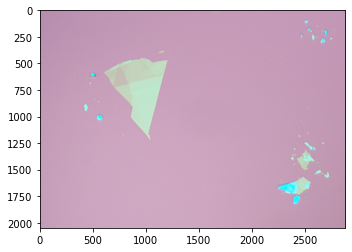

Image in RGB:


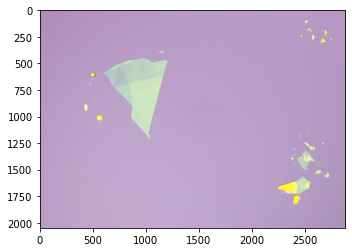

In [34]:
# Example of what the code does to the image

file_dir =r"C:\Users\manue\OneDrive\Desktop\REU Northwestern\Manuel\NiBr2\2022-06-20\case 1\chip 1-05.jpg"


# This library reads an image.
image = cv2.imread(file_dir)

print("Image in BGR:")
plt.imshow(image)
plt.show()

# The image is opened in BGR so in the following line we turn it into RGB 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Image in RGB:")
plt.imshow(image)
plt.show()



G Image segmented:



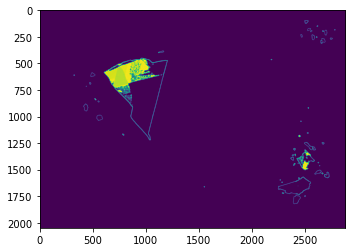

In [35]:
Background_val = 185

channel_g = image [:,:,1]

g_ratios = (np.abs(channel_g - Background_val))/(Background_val + channel_g)

mask_g = np.logical_or(g_ratios<0.0, g_ratios > 0.2)

#ratios[mask] = 0
channel_g[mask_g] = 0

print("")
print("G Image segmented:")
plt.imshow(channel_g) 
print("")


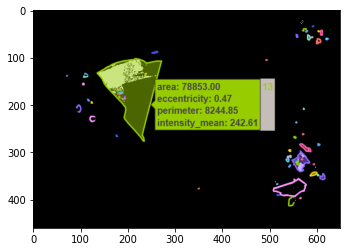

In [41]:

# Binary image, post-process the binary mask and compute labels
threshold = filters.threshold_otsu(channel_g)
mask = channel_g > threshold
mask = morphology.remove_small_objects(mask, 50)
mask = morphology.remove_small_holes(mask, 50)
labels = measure.label(mask)

fig = px.imshow(channel_g, binary_string=True)
fig.update_traces(hoverinfo='skip') # hover is only for label info

props = measure.regionprops(labels, channel_g)
properties = ['area', 'eccentricity', 'perimeter', 'intensity_mean']

# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(1, labels.max()):
    label_i = props[index].label
    contour = measure.find_contours(labels == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name):.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label_i,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))

plotly.io.show(fig)

image_output = cv2.imread(r"C:\Users\manue\Downloads\Test image.png")
plt.imshow(image_output)